# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо определить параметры, оказывающие наибольшее влияние на оценку стоимости недвижимости.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Общее

In [1]:
# Импортируем библиотеки
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

### 1. Изучим общую информацию. 

##### Просмотрим информацию в файле

In [2]:
# Откроем и ознакомимся с информацией в файле
!head /datasets/real_estate_data.csv #Разделитель \t

In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
#Проверим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

###### Наблюдение:
1. Присутствуют пропущенные значения - необходима обработка пропусков
2. Некоторые значения имеют значения float - перевести в целочисленные
3. 'is_apartment' - перевести тип float в bool

##### Переместим колонки. Пруды к прудам, площадь к площади

In [5]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [6]:
data = data[['locality_name', 'last_price', 'rooms', 'total_area', 'living_area', 'kitchen_area',
       'ceiling_height', 'floor', 'floors_total',
       'is_apartment', 'studio', 'open_plan', 'balcony',
       'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 
       'first_day_exposition', 'days_exposition', 'total_images']]

##### Проверим долю пропусков

In [7]:
(data.isna().sum(axis=0).sort_values(ascending = False) / len(data)).apply(lambda x: '{:.2%}'.format(x))

is_apartment            88.29%
parks_nearest           65.91%
ponds_nearest           61.56%
balcony                 48.61%
ceiling_height          38.80%
airports_nearest        23.38%
cityCenters_nearest     23.29%
ponds_around3000        23.28%
parks_around3000        23.28%
days_exposition         13.42%
kitchen_area             9.61%
living_area              8.03%
floors_total             0.36%
locality_name            0.21%
rooms                    0.00%
total_area               0.00%
last_price               0.00%
total_images             0.00%
floor                    0.00%
open_plan                0.00%
first_day_exposition     0.00%
studio                   0.00%
dtype: object

###### Наблюдение:
1. Значительное количество пропусков в отдельных колонках - более 20 % ( в некоторых до 60...80%)
2. 'parks_nearest', 'ponds_nearest' - содержит больше пропусков (до 65%), однако релевантные колонки 'parks_around3000', 'ponds_around3000' - содержат всего не более 24% пропусков - можно воспользоваться информацией о наличии ближайшего пруда/парка.
3. Также возможна замена пропусков из релевантных колонок (например заполнение колонок 'living_area', 'kitchen_area', из колонки total_area' учитывая их среднее или медианное отношение)

Т.к. колонки 'parks_nearest', 'ponds_nearest', 'parks_around3000', 'ponds_around3000', 'airports_nearest', 'cityCenters_nearest', были получены автоматически, то причина возникновения пропуска может являться в том, что пользователь не указал адрес, либо указал адрес с ошибкой и программа не смогла его определить. Также возможно, что произошел баг в программе, следует вернуть вопрос о пропусках соответствующим лицам.

##### Посмотрим основные метрики данных

In [8]:
#Изменим вид отображения данных на более привычный
pd.options.display.float_format = '{:,.2f}'.format 
data.describe()

,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,floor,floors_total,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_images
count,"23,699.00","23,699.00","23,699.00","21,796.00","21,421.00","14,504.00","23,699.00","23,613.00","12,180.00","18,157.00","18,180.00","18,181.00","8,079.00","18,181.00","9,110.00","20,518.00","23,699.00"
mean,"6,541,548.77",2.07,60.35,34.46,10.57,2.77,5.89,10.67,1.15,"28,793.67","14,191.28",0.61,490.80,0.77,517.98,180.89,9.86
std,"10,887,013.27",1.08,35.65,22.03,5.91,1.26,4.89,6.60,1.07,"12,630.88","8,608.39",0.80,342.32,0.94,277.72,219.73,5.68
min,"12,190.00",0.00,12.00,2.00,1.30,1.00,1.00,1.00,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00,0.00
25%,"3,400,000.00",1.00,40.00,18.60,7.00,2.52,2.00,5.00,0.00,"18,585.00","9,238.00",0.00,288.00,0.00,294.00,45.00,6.00
50%,"4,650,000.00",2.00,52.00,30.00,9.10,2.65,4.00,9.00,1.00,"26,726.00","13,098.50",0.00,455.00,1.00,502.00,95.00,9.00
75%,"6,800,000.00",3.00,69.90,42.30,12.00,2.80,8.00,16.00,2.00,"37,273.00","16,293.00",1.00,612.00,1.00,729.00,232.00,14.00
max,"763,000,000.00",19.00,900.00,409.70,112.00,100.00,33.00,60.00,5.00,"84,869.00","65,968.00",3.00,"3,190.00",3.00,"1,344.00","1,580.00",50.00


###### Наблюдение:
1. last_price - Значительные отличия среднеего и медианы, присутствуют артефакты превышающие среднее более чем в 100 раз, подозрительно низкое минимальное значение.
2. rooms, total_area, living_area, kitchen_area - впринципе ок, но встречаются аномально большие значения. (проверить минимумы, максимумы)
3. ceiling_height - среднее и медиана имеют близкие значения (однако есть аномалии в виде потолков в 100 м и 1 м)
4. cityCenters_nearest, airports_nearest - среднее и медиана имеют близкие значения
5. parks_nearest - имеет максимальное значение 3190 - проверить соответствие parks_around3000

### Вывод

Общая информация:
1. В данных присутствуют пропущенные значения - необходима обработка пропусков
2. Некоторые значения имеют значения float - перевести в целочисленные
3. 'is_apartment' - перевести тип float в bool

Содержание пропусков:
1. Значительное количество пропусков в отдельных колонках - более 20 % ( в некоторых до 60...80%)
2. 'parks_nearest', 'ponds_nearest' - содержит больше пропусков (до 65%), однако релевантные колонки 'parks_around3000', 'ponds_around3000' - содержат всего не более 24% пропусков - можно воспользоваться информацией о наличии ближайшего пруда/парка.
3. Также возможна замена пропусков из релевантных колонок (например заполнение колонок 'living_area', 'kitchen_area', из колонки total_area' учитывая их среднее или медианное отношение)

Основные метрики:
1. last_price - Значительные отличия среднеего и медианы, присутствуют артефакты превышающие среднее более чем в 100 раз, подозрительно низкое минимальное значение.
2. rooms, total_area, living_area, kitchen_area - впринципе ок, но встречаются аномально большие значения. (проверить минимумы, максимумы)
3. ceiling_height - среднее и медиана имеют близкие значения (однако есть аномалии в виде потолков в 100 м и 1 м)
4. cityCenters_nearest, airports_nearest - среднее и медиана имеют близкие значения
5. parks_nearest - имеет максимальное значение 3190 - проверить соответствие parks_around3000

### 2. Предобработка данных

#### 2.1. Проверим дубликаты

In [9]:
data.duplicated().sum() #Дубликатов не наблюдается

0

Проверим столбец 'locality_name'

In [10]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Наблюдается наличие разного написания слов 'посЕлок' и 'посЁлок'.
Приведем к единому виду

In [11]:
data['locality_name'].str.lower().value_counts()

санкт-петербург                        15721
посёлок мурино                           522
посёлок шушары                           440
всеволожск                               398
пушкин                                   369
                                       ...  
поселок лисий нос                          1
садовое товарищество приладожский          1
деревня пчева                              1
деревня раздолье                           1
поселок городского типа кондратьево        1
Name: locality_name, Length: 364, dtype: int64

In [12]:
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')

In [13]:
data['locality_name'].str.lower().value_counts()

санкт-петербург                        15721
поселок мурино                           556
поселок шушары                           440
всеволожск                               398
пушкин                                   369
                                       ...  
садовое товарищество рахья                 1
деревня новолисино                         1
поселок мыза-ивановка                      1
поселок тёсово-4                           1
поселок городского типа кондратьево        1
Name: locality_name, Length: 330, dtype: int64

In [14]:
data['locality_name'] = data['locality_name'].str.lower()

In [15]:
data.duplicated().sum()

0

После приведения слов 'посёлок' и 'поселок' к единому виду, было длинна списка уникалных значений сократилась на 34 позиции, однако при провеки дубликатов во всем ДатаФрейме последние выявлены не были

#### 2.2. Заполним пропуски

Пропуски обнаружены в следующих стоблцах:
+ is_apartment            88.29%
+ parks_nearest           65.91%
+ ponds_nearest           61.56%
+ balcony                 48.61%
+ ceiling_height          38.80%
+ airports_nearest        23.38%
+ cityCenters_nearest     23.29%
+ ponds_around3000        23.28%
+ parks_around3000        23.28%
+ days_exposition         13.42%
+ kitchen_area             9.61%
+ living_area              8.03%
+ floors_total             0.36%
+ locality_name            0.21%

###### is_apartment
Возможна версия, что пользователь не стал заполнять колонку Аппартаменты по причине не понимания ее смысла. В таком случае если бы он знал, что у него Аппартаменты, то он точно бы оветил на этот вопрос.
Однако разница в правовом статусе между Апартаментами и Жилыми помещениями может значительно повлиять на цену, что исказит оценку.
т.к. это колонка с типом bool, на данном этапе, до выяснения подробностей, предлагается заменить пропуски на значение '2'

In [16]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [17]:
data['is_apartment'].fillna(2, inplace=True)

In [18]:
data['is_apartment'].value_counts()

2        20924
False     2725
True        50
Name: is_apartment, dtype: int64

###### parks and ponds _nearest
Т.к. в колонках с указанием ближайших парков и прудов имеется примерно 61..65 пропусков, то воспользуемся значениями из колонок _around3000.

In [19]:
# Корректность 'parks_around3000' при parks_nearest > 3000
data.query('parks_nearest > 3000')['parks_around3000'] #Все ок

1590    0.00
10959   0.00
19208   0.00
19430   0.00
Name: parks_around3000, dtype: float64

In [20]:
parks_na_query = (data['parks_nearest'].isna()) & (data['parks_around3000'].isna() == False)
data.query('@parks_na_query')[['parks_nearest', 'parks_around3000']].describe()

,parks_nearest,parks_around3000
count,0.00,"10,102.00"
mean,nan,0.00
std,nan,0.00
min,nan,0.00
25%,nan,0.00
50%,nan,0.00
75%,nan,0.00
max,nan,0.00


Как показывает таблица выше, количество парков в радиусе 3000 метров соответствует нулевому значению, скорее всего при заполнении 'parks_nearest' в данных случаях был сделан намеренный пропуск.
Проверим, каким населенным пунктам соответствуют пропуски

In [21]:
data.query('@parks_na_query')['locality_name'].unique()

array(['поселок шушары', 'поселок парголово', 'санкт-петербург',
       'ломоносов', 'пушкин', 'колпино', 'поселок металлострой',
       'петергоф', 'сестрорецк', 'красное село', 'поселок понтонный',
       'зеленогорск', 'поселок молодёжное', 'поселок александровская',
       nan, 'поселок стрельна', 'поселок песочный',
       'поселок петро-славянка', 'поселок репино', 'павловск',
       'кронштадт', 'поселок сапёрный', 'поселок щеглово',
       'поселок лисий нос', 'поселок левашово', 'поселок белоостров',
       'поселок мурино', 'поселок усть-ижора'], dtype=object)

Как видим восновном это деревни и поселки, хотя встречается и Санкт-Петербург. Т.к. наличие парка наиболее критично для больших городов, и максимальное значение в колонке 'parks_nearest' соответствует 3190, то примем для замены пустых значений значение 4000 для Санкт-Петербурга, что достаточно далеко, чтобы не указывать ближайший парк.
Для остальных населенных пунктов примем 3001

In [22]:
data.loc[parks_na_query & (data['locality_name'] == 'санкт-петербург'), 'parks_nearest'] = 4000

In [23]:
#Обновим запрос
parks_na_query = (data['parks_nearest'].isna()) & (data['parks_around3000'].isna() == False)

In [24]:
data.loc[parks_na_query & (data['locality_name'] != 'санкт-петербург'), 'parks_nearest'] = 3001
del parks_na_query

Аналогично сделаем для ponds_nearest

In [25]:
ponds_na_query = (data['ponds_nearest'].isna()) & (data['ponds_around3000'].isna() == False)
data.query('@ponds_na_query')[['ponds_nearest', 'ponds_around3000']].describe()

,ponds_nearest,ponds_around3000
count,0.00,"9,071.00"
mean,nan,0.00
std,nan,0.00
min,nan,0.00
25%,nan,0.00
50%,nan,0.00
75%,nan,0.00
max,nan,0.00


In [26]:
data.query('@ponds_na_query')['locality_name'].unique()

array(['поселок шушары', 'поселок парголово', 'санкт-петербург',
       'ломоносов', 'колпино', 'поселок металлострой', 'пушкин',
       'петергоф', 'сестрорецк', 'красное село', 'поселок понтонный',
       'зеленогорск', 'поселок молодёжное', 'поселок стрельна', nan,
       'поселок песочный', 'поселок репино', 'павловск',
       'поселок щеглово', 'кронштадт', 'поселок лисий нос',
       'поселок левашово', 'поселок усть-ижора'], dtype=object)

In [27]:
data.loc[ponds_na_query & (data['locality_name'] == 'санкт-петербург'), 'ponds_nearest'] = 4000

#Обновим запрос
ponds_na_query = (data['ponds_nearest'].isna()) & (data['ponds_around3000'].isna() == False)

data.loc[ponds_na_query & (data['locality_name'] != 'санкт-петербург'), 'ponds_nearest'] = 3001

del ponds_na_query

###### parks and ponds _around3000
Примем гипотезу, что при отсутсвии парков и прудов вокругепрограмма заполняла пустыми значениями, всвязи с этим на данном этапе заменим NaN на -1, чтобы отличать отсутствие парков и прудов вокруге и при возможности восстановить NaN при обновлении информации.

In [28]:
data['parks_around3000'].fillna(-1, inplace=True)
data['ponds_around3000'].fillna(-1, inplace=True)

Заполним аналогично parks and ponds _nearest

In [29]:
data.loc[(data['locality_name'] != 'санкт-петербург'), ['ponds_nearest', 'parks_nearest']] = (
    data.loc[(data['locality_name'] != 'санкт-петербург'), ['ponds_nearest', 'parks_nearest']].fillna(3001)
)

In [30]:
data.loc[(data['locality_name'] == 'санкт-петербург'), ['ponds_nearest', 'parks_nearest']] = (
    data.loc[(data['locality_name'] == 'санкт-петербург'), ['ponds_nearest', 'parks_nearest']].fillna(4000)
)

###### balcony
Для решения поставленной задачи примем, что пропуски в колокне 'balcony' соответствует его отсутствию, т.к. пользователь не стал уточнять его наличие, который в свою очередь является значительным аргументом при выборе квартиры

In [31]:
data['balcony'].fillna(0, inplace=True)

###### ceiling_height
Скорее всего значениям с пропусками соответствует среднее значение высоты потолка, которое пользователь предпочел не указывать, всвязи с этим, т.к. имеются значительные выбросы в этом значении, заменим пропуски медианой.

In [32]:
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

###### airports_nearest
Как можно заметить, для некоторых населенных пунктов пропуски в этой колонке присутствуют во всех объявлениях, а для других городов только частично пропущены.
Заполним средними значениями для населенных пуктов для которых у нас частично имеются данные.

In [33]:
a = data.groupby('locality_name')['airports_nearest'].mean()
b = a.loc[a.isna() == False]
for city in b.index:
    data.loc[data['locality_name'] == city, 'airports_nearest'] =(
        data.loc[data['locality_name'] == city, 'airports_nearest'].fillna(b[city])
    )
del a, b

У нас остались только поселки, деревни и небольшие города, т.к. в основной задаче они не фигурируют, то заполним значения средним по всему датасету

In [34]:
data['airports_nearest'].fillna(data['airports_nearest'].mean(), inplace=True)

###### cityCenters_nearest
т.к. при проверке встречается Спб, проведем анализ пропущеных значений только по 'locality_name' == 'санкт-петербург'

In [35]:
query_cityCenters_nearest_isna = data['cityCenters_nearest'].isna()
query_spb = data['locality_name'] == 'санкт-петербург'
rooms_grouped_isna_spb = data.query('@query_cityCenters_nearest_isna & @query_spb').groupby('rooms')['last_price'].median()
rooms_grouped_spb_only = data.query('@query_spb').groupby('rooms')['last_price'].median()
difference = rooms_grouped_isna_spb - rooms_grouped_spb_only
difference

rooms
0              nan
1       690,000.00
2     1,449,500.00
3     5,843,000.00
4     3,950,000.00
5    -5,200,000.00
6    -5,000,000.00
7    56,547,038.00
8              nan
9              nan
10             nan
11             nan
12             nan
14             nan
15             nan
16             nan
19             nan
Name: last_price, dtype: float64

Проверим для квартир на растоянии от центра примерно соответствующему среднему по СПб

In [36]:
mean_cityCenters_spb = data.loc[(data['locality_name'] == 'санкт-петербург'), 'cityCenters_nearest'].mean()
rooms_grouped_spb_mean_cityCenters = data.loc[(data['locality_name'] == 'санкт-петербург')\
         & ((mean_cityCenters_spb - 2000) <= data['cityCenters_nearest'])\
         & (data['cityCenters_nearest']<= (mean_cityCenters_spb + 2000))].groupby('rooms')['last_price'].median()

In [37]:
rooms_grouped_isna_spb - rooms_grouped_spb_mean_cityCenters


rooms
0              nan
1       700,000.00
2     1,749,500.00
3     6,543,000.00
4     7,500,000.00
5    -5,000,000.00
6             0.00
7              nan
9              nan
10             nan
Name: last_price, dtype: float64

Квартиры с пропусками значительно дороже

In [38]:
sbp_na_cityCenters_nearest_percent = (
    data.query('@query_spb')['cityCenters_nearest'].isna().sum()  /  len(data.query('@query_spb'))
)
print('Доля пропусков для "cityCenters_nearest" в Спб: {:.2%}'.format(sbp_na_cityCenters_nearest_percent))

Доля пропусков для "cityCenters_nearest" в Спб: 0.39%


Как видно цены для значений с пропусками в "cityCenters_nearest" в Спб на квартиры выше медианного значения для Спб в среднем. Это может сильно повлиять на результат, если заполнить пропуски медианой или среднем по Спб.
Беря во внимание выше сказанное удалим пропуски соответствующие колонке "cityCenters_nearest" при 'locality_name' == 'санкт-петербург'

In [39]:
data.loc[data['locality_name'] == 'санкт-петербург'] = (
    data.loc[(data['locality_name'] == 'санкт-петербург') & (~data['cityCenters_nearest'].isna())]
)
data = data.dropna(how='all').reset_index(drop=True)

Проверим расстояния до центра города для населенных пунктов не являющихся Спб и далее 12000 метров от центра

In [40]:
data\
    .query('(locality_name != "санкт-петербург") & (cityCenters_nearest > 12000)')\
    .sort_values(by = 'cityCenters_nearest')\
    [['locality_name', 'cityCenters_nearest']] \
    .head(20)

,locality_name,cityCenters_nearest
12848,NaN,"12,332.00"
7579,NaN,"12,332.00"
5689,NaN,"16,788.00"
18388,поселок шушары,"17,012.00"
6340,поселок шушары,"17,017.00"
15352,поселок шушары,"17,231.00"
22005,поселок шушары,"17,231.00"
8371,поселок шушары,"17,231.00"
4745,поселок шушары,"17,231.00"
1380,поселок шушары,"17,231.00"


Есть пропуски, сгруппируем по городам, чтобы определить медианное значение для каждого

In [41]:
locality_name_grouped = data.groupby('locality_name').median()
locality_name_grouped\
    .loc[locality_name_grouped['cityCenters_nearest'].notna()]\
    .sort_values(by = 'cityCenters_nearest')\
    ['cityCenters_nearest']\
    .head(15)

locality_name
санкт-петербург           12,244.50
поселок парголово         19,311.00
поселок мурино            21,888.00
поселок стрельна          23,506.00
поселок шушары            24,212.00
поселок левашово          25,727.00
поселок песочный          26,099.50
поселок петро-славянка    27,165.00
поселок александровская   27,468.00
поселок металлострой      27,602.00
пушкин                    27,930.50
поселок усть-ижора        28,222.50
поселок лисий нос         28,226.00
красное село              29,140.50
колпино                   32,018.00
Name: cityCenters_nearest, dtype: float64

За точку отчета принят центр СПБ, проверим максимальную удаленность в Спб

In [42]:
data\
    .query('locality_name == "санкт-петербург"')\
    .sort_values(by = 'cityCenters_nearest', ascending = False)\
    [['locality_name', 'cityCenters_nearest']] \
    .head(10)

,locality_name,cityCenters_nearest
12130,санкт-петербург,"29,493.00"
13000,санкт-петербург,"29,343.00"
16747,санкт-петербург,"29,263.00"
19840,санкт-петербург,"28,806.00"
11625,санкт-петербург,"28,644.00"
10774,санкт-петербург,"28,644.00"
809,санкт-петербург,"28,109.00"
22855,санкт-петербург,"28,018.00"
1106,санкт-петербург,"28,018.00"
17756,санкт-петербург,"28,018.00"


Как видно из таблиц выше, есть достаточно удаленные квартиры от центра Спб, при это медиана расстояния примерно соответствует 12000

Заполним для начала пропуски в 'locality_name', после этого вернемся к 'cityCenters_nearest'

###### 'locality_name'
Насколько видно из предыдущих результатов значения расстояния от центра менее 12 000 скорее всего соответствуют Спб, тоэтому заполним эти значения значением 'санкт-петербург'

In [43]:
data\
    .loc[(data['locality_name'].isna()) & (data['cityCenters_nearest'] < 17000), 'locality_name']\
    = data\
        .loc[(data['locality_name'].isna()) & (data['cityCenters_nearest'] < 17000), 'locality_name']\
        .fillna('санкт-петербург')

In [44]:
data.loc[data['locality_name'].isna()] #Проверим

,locality_name,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,floor,floors_total,is_apartment,...,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,first_day_exposition,days_exposition,total_images
2025,NaN,"5,398,000.00",3.00,80.00,42.60,18.60,2.65,2.00,4.00,2,...,0.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",2017-05-30T00:00:00,34.00,6.00
2594,NaN,"3,351,765.00",1.00,42.70,15.60,10.70,2.65,3.00,24.00,2,...,0.00,"22,041.00","17,369.00",0.00,"3,001.00",1.00,374.00,2015-09-20T00:00:00,276.00,20.00
2623,NaN,"5,130,593.00",2.00,62.40,33.10,8.20,2.65,21.00,24.00,2,...,0.00,"22,041.00","17,369.00",0.00,"3,001.00",1.00,374.00,2015-10-11T00:00:00,256.00,2.00
6746,NaN,"4,895,892.00",2.00,60.70,31.90,12.20,2.65,3.00,24.00,2,...,0.00,"22,041.00","17,369.00",0.00,"3,001.00",1.00,374.00,2015-03-12T00:00:00,468.00,20.00
8965,NaN,"4,850,000.00",3.00,103.10,68.10,16.70,2.65,4.00,nan,2,...,0.00,"19,659.00","31,813.00",0.00,"3,001.00",0.00,"3,001.00",2018-07-10T00:00:00,28.00,10.00
13192,NaN,"2,919,911.00",1.00,29.40,21.10,nan,2.75,2.00,24.00,2,...,0.00,"22,041.00","17,369.00",0.00,"3,001.00",1.00,374.00,2015-03-12T00:00:00,470.00,1.00
13658,NaN,"3,500,000.00",3.00,71.00,45.60,8.00,2.75,1.00,2.00,False,...,2.00,"20,234.00","23,659.00",0.00,"3,001.00",2.00,296.00,2016-06-23T00:00:00,92.00,7.00
14241,NaN,"4,422,000.00",2.00,60.00,32.00,11.90,2.75,14.00,23.00,2,...,0.00,"22,041.00","17,369.00",0.00,"3,001.00",1.00,374.00,2016-03-23T00:00:00,90.00,2.00
14310,NaN,"3,611,000.00",1.00,53.50,25.80,nan,2.65,3.00,4.00,False,...,1.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",2017-04-27T00:00:00,92.00,3.00
16460,NaN,"4,995,573.00",2.00,56.90,29.20,10.90,2.65,14.00,24.00,2,...,0.00,"22,041.00","17,369.00",0.00,"3,001.00",1.00,374.00,2016-06-17T00:00:00,4.00,2.00


остальные значения отбросим, т.к. судя по расстоянию они не относятся к Спб, в таблица выше наблюдается некотарая зависимось между названием и расстоянием, она указывает, что скорее всего это не Спб

In [45]:
data.dropna(subset=['locality_name'], inplace=True)
data = data.reset_index(drop=True) #почему-то без "data =" не меняет индекс в RangeIndex

вернемся к cityCenters_nearest

###### cityCenters_nearest этап 2
Заполним по аналогии с "airports_nearest"

In [46]:
a = locality_name_grouped['cityCenters_nearest']
b = a.loc[a.notna()]
for city in b.index:
    data.loc[data['locality_name'] == city, 'cityCenters_nearest'] =(
        data.loc[data['locality_name'] == city, 'cityCenters_nearest'].fillna(b[city])
    )
del a, b
locality_name_grouped

,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,floor,floors_total,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_images
locality_name,,,,,,,,,,,,,,,,,
бокситогорск,"785,000.00",2.00,44.50,29.50,6.00,2.65,2.50,5.00,0.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",45.00,7.50
волосово,"1,800,000.00",2.00,49.55,29.80,8.30,2.60,2.00,5.00,1.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",114.00,6.50
волхов,"1,600,000.00",2.00,48.00,30.30,6.80,2.65,3.00,5.00,0.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",104.00,8.00
всеволожск,"3,450,000.00",2.00,53.55,30.00,10.00,2.65,4.00,9.00,0.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",123.00,10.00
выборг,"2,897,000.00",2.00,50.20,30.00,8.00,2.65,3.00,5.00,0.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",99.50,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
сосновый бор,"3,600,000.00",2.00,48.00,30.00,8.20,2.65,4.00,9.00,0.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",45.00,13.00
сясьстрой,"1,600,000.00",2.00,45.70,31.00,6.00,2.65,4.00,5.00,1.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",168.00,8.50
тихвин,"1,850,000.00",2.00,48.00,28.50,8.00,2.65,4.00,5.00,0.00,"29,498.73",nan,-1.00,"3,001.00",-1.00,"3,001.00",45.00,5.00


т.к. при выборочной проверке в Яндекс картах значения 'cityCenters_nearest' для населенных пунктов сильно разнятся (от 38км до 204 км), а также принимая во внимание что в основном задании они не фигурируют, то предлагается их удалить.

In [47]:
data.dropna(subset=['cityCenters_nearest'], inplace=True)
data = data.reset_index(drop=True) #почему-то без "data =" не меняет индекс в RangeIndex

###### days_exposition
Сравним основные метрики



Изменим для начала тип данных в колонке 'first_day_exposition' на datetime

In [48]:
data['first_day_exposition'] = (
    pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
)

Проверим какой дате соответствовал последний день продажи

In [49]:
def first_day_plus_days_exposition (df):
    first_day = df['first_day_exposition']
    nuber_of_days = df['days_exposition']
    try:
        desired_date = first_day + pd.DateOffset(days=nuber_of_days)
    except:
        desired_date = first_day
    return desired_date

data['last_day_exposition'] = data.apply(first_day_plus_days_exposition, axis=1)


In [50]:
data.loc[data['days_exposition'].notna()][['first_day_exposition', 'days_exposition', 'last_day_exposition']]\
    .sort_values(by='last_day_exposition', ascending=False)

,first_day_exposition,days_exposition,last_day_exposition
11868,2019-04-16,16.00,2019-05-02
6034,2019-02-25,66.00,2019-05-02
11377,2018-11-03,180.00,2019-05-02
12852,2019-04-30,2.00,2019-05-02
11225,2018-12-10,143.00,2019-05-02
...,...,...,...
5482,2016-02-24,113.00,2016-06-16
14767,2016-05-24,23.00,2016-06-16
12601,2016-03-14,94.00,2016-06-16
9911,2016-06-07,9.00,2016-06-16


Проверим тоже самое с учетом пропущеных значений

In [51]:
data[['first_day_exposition', 'days_exposition', 'last_day_exposition']]\
    .sort_values(by='last_day_exposition', ascending=False)

,first_day_exposition,days_exposition,last_day_exposition
9819,2019-05-03,nan,2019-05-03
17317,2019-05-03,nan,2019-05-03
8647,2019-05-03,nan,2019-05-03
9685,2019-05-03,nan,2019-05-03
3500,2019-05-03,nan,2019-05-03
...,...,...,...
4706,2014-12-09,nan,2014-12-09
5485,2014-12-08,nan,2014-12-08
2585,2014-11-27,nan,2014-11-27
3044,2014-11-27,nan,2014-11-27


Как видно крайние даты для значений с пропусками и без пропусков примерно соответствуют и находятся в диапазоне начала мая 2019 года. Скорее всего эти статистика по продажам квартир прекратилась вестись в мае 2019. И пропуски соответствуют квартирам, которые еще не продались, таким образом пропуски соответствуют отсутствии продажи.
НО пропуски есть и для более ранних дат (например в 2014 году) скорее всего 2 версии их возникновения - либо квартира до сих пор продается - что мало вероятно, либо пользователь не подтвердил продажу квартиры на ресурсе Яндекс.Недвижимость.

Проверим как распределяются пропуски по месяцам, для этого забегая вперед добавим столбцы с Годом и Месяцем даты публикации.

###### Добавление столбцов


In [52]:
# Получим год и месяц из столбца с датой и временем
data['year_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year
data['month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month

Проверим количество пропусков по годам

In [53]:
data_exposition_isna = data\
    .loc[data['days_exposition'].isna(), ['days_exposition',]].isna()\
    .merge(data[['year_exposition', 'month_exposition']], left_index=True, right_index=True)\
    .pivot_table(index='year_exposition', values='days_exposition', aggfunc='count')

data_exposition_isna['ratio'] = ((
    data_exposition_isna['days_exposition']
    / 
    data_exposition_isna['days_exposition'].sum()).apply(lambda x: '{:.2%}'.format(x))
)
    

In [54]:
data_exposition_isna.sort_values(by='days_exposition', ascending=False)

,days_exposition,ratio
year_exposition,,
2019,1335,57.44%
2018,665,28.61%
2017,204,8.78%
2015,59,2.54%
2016,46,1.98%
2014,15,0.65%


Как видно, большая часть квартир не продалась в 2019 и 2018 годах, что подтверждает гитотезу о том, что сбор статистики прекратился до продажи этих квартир.
Проверить продались ли вкартиры для более ранних годов или пользователь забыл указать подтверждение о продаже не предоставляется возможным.
Предлагается проверить от каких величин зависит 'days_exposition'

In [55]:
def corr_chek(df, column):
    """
    Функция возращает таблицу с первыми 5-ю максимальными значениями
    и 5-ю минимальными значениями корреляции,
    для заданной колонки.
    Полученная таблица отсортирована по убыванию
    """
    s1 = df[column]
    corr_values = []
    columns = []
    for name in df.columns:
        s2 = df[name]
        try:
            if name != column:
                corr_value = s1.corr(s2)
        except:
            corr_value = None
        corr_values.append(corr_value)
        columns.append(name)
    d = {'column': columns, 'corr': corr_values}
    corr_data = pd.DataFrame(data=d)
    corr_data = corr_data.set_index('column').sort_values(by='corr', ascending=False).dropna()
    max_corr_data = corr_data.head(5).append(corr_data.tail(5))
    return max_corr_data

Проверим корреляцию `'days_exposition'` с остальными данными

In [56]:
corr_chek(data, 'days_exposition')

,corr
column,
total_area,0.17
living_area,0.16
rooms,0.14
kitchen_area,0.12
last_price,0.09
parks_nearest,-0.05
floors_total,-0.06
ponds_nearest,-0.06
cityCenters_nearest,-0.06


как видно, наиболее ярко выражена корреляция с годом публикации

Проверим основные метрики

In [57]:
data['days_exposition'].describe()

count   16,430.00
mean       181.32
std        222.45
min          1.00
25%         43.00
50%         95.00
75%        231.00
max      1,572.00
Name: days_exposition, dtype: float64

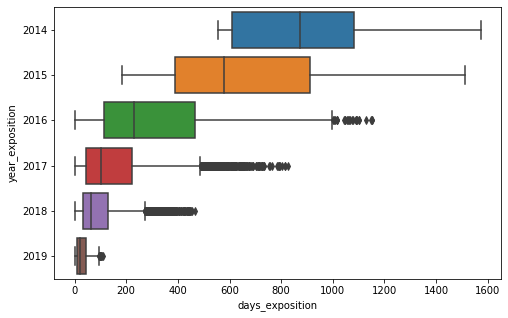

In [58]:
cols = ['days_exposition', 'year_exposition']
sns.boxplot(y="year_exposition", x="days_exposition", data=data[cols], orient="h")

Время продажи существенно снижается год-от года, возможно:
1. Возможно люди чаще начинают пользоваться сервисом
2. 2014 год кризисный и люди боялись производить дорогостоющие операции.

Проверим сколько пропущеных значений соответствует для каждого года

In [59]:
def grouped_by_year_na (df, column):
    """
    Функция возвращает таблицу c количеством пропусков по годам параметра 'column'
    """
    df_list = df['year_exposition'].unique()
    column_na_count = []
    column_notna_count = []
    #Отсортируем З.Ы. более удобного способа не нашел(((
    for i in range(len(df_list)):
        j=i+1
        for j in range(len(df_list)):
            if df_list[i]<df_list[j]:
                temp = df_list[i]
                df_list[i] = df_list[j]
                df_list[j] = temp
    for year in df_list:
        na_count = df.query('year_exposition == @year')[column].isna().sum()
        column_na_count.append(na_count)
        
        notna_count = df.query('year_exposition == @year')[column].count()
        column_notna_count.append(notna_count)
    d = pd.DataFrame({'na_count': column_na_count, 'notna_count': column_notna_count}, index=df_list)
    d['na_deal'] = (d['na_count']/(d['na_count'] + d['notna_count'])).apply(lambda x: '{:.2%}'.format(x))
    d['notna_deal'] = (d['notna_count']/(d['na_count'] + d['notna_count'])).apply(lambda x: '{:.2%}'.format(x))
    return d

Проверим количество пустых, заполненых значений по годам и их доли

In [60]:
grouped_by_year_na (data, 'days_exposition')

,na_count,notna_count,na_deal,notna_deal
2014,15,102,12.82%,87.18%
2015,59,933,5.95%,94.05%
2016,46,2191,2.06%,97.94%
2017,204,6437,3.07%,96.93%
2018,665,5869,10.18%,89.82%
2019,1335,898,59.79%,40.21%


Как видим количество количество пропусков резко увеличивается начиная с 2017 года с нарастающим эффектом, скорее всего это связано с "затяжными" продажами (но возможно связано с тем, что пользователь не указал о завершении продажи).
Если принимаем, что пропуски - отсутствие продажи, то для 2016, 2017 года процент не проданых квартир составил 2...3% 
Достаточно полные данные, чтобы взять их за образец.

Заполним пропуски в соответствии с годом средним значенем, чтобы учитывать "долгие" продажи
т.к. мы имеем данные всего для 1-го полугодия 2019 года, а также в 2018 нет влияния "долгих" продаж, т.к. скорее всего они произойдут за временными границами нашей выборки, то для заполнения 2018-го и 2019-го года воспользуемся средним для 2017-го года.

In [61]:
#Определим среднее
grouped_by_year = data.groupby('year_exposition').mean().astype(int)
grouped_by_year['days_exposition']#для 2018-2019 действительно низкое значение

year_exposition
2014    903
2015    656
2016    316
2017    156
2018     93
2019     30
Name: days_exposition, dtype: int64

In [62]:
a = grouped_by_year['days_exposition']

for year in a.index:
    if year < 2018:
        data.loc[(data['year_exposition'] == year)
                 & (data['days_exposition'].isna()), 'days_exposition'] = a[year]
    else:
        data.loc[(data['year_exposition'] == year)
                 & (data['days_exposition'].isna()), 'days_exposition'] = a[2017]
del a

Проверим метрики еще раз

In [63]:
data['days_exposition'].describe()
# медиана увеличелась с 95 - до 120, выглядяит правдоподобно,
#т.к. пропускам вероятнее всего соответствовани "затяжные" продажи

count   18,754.00
mean       180.75
std        211.18
min          1.00
25%         46.00
50%        120.00
75%        206.00
max      1,572.00
Name: days_exposition, dtype: float64

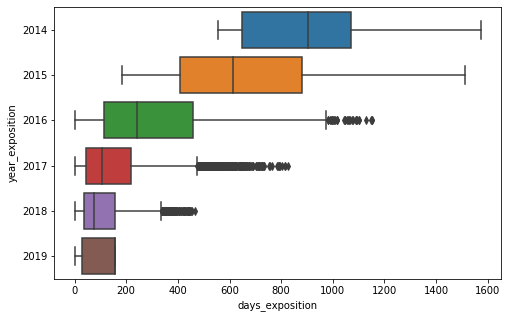

In [64]:
sns.boxplot(y="year_exposition", x="days_exposition", data=data[cols], orient="h")
#Наглядные значения в 2019 году, выглядят более правдоподобно

In [65]:
corr_chek(data, 'days_exposition') #Корреляция незначительно изменилась

,corr
column,
total_area,0.15
living_area,0.15
rooms,0.13
kitchen_area,0.12
last_price,0.09
parks_nearest,-0.05
floors_total,-0.05
ponds_nearest,-0.06
cityCenters_nearest,-0.06


In [66]:
data.loc[data['year_exposition'] == 2019, 'days_exposition'].describe()

count   2,233.00
mean      105.36
std        63.51
min         1.00
25%        30.00
50%       156.00
75%       156.00
max       156.00
Name: days_exposition, dtype: float64

#### Вывод
В ячейке `'days_exposition'` пропуски заполнены средним значением для каждого года, наблюдается увеличение медианного значения в 2019 году по сравнению с 2018 годом, но данный факт скорее связан с тем, что в 2019 60% пропусков в данной колонке, это наиболее вероятно обусловлено тем, что выборка данных заканчивается 1-м полугодием 2019 года.

###### kitchen_area и living_area
Т.к. в объемом проекта оценка влияния этих параметров не предусматривается, то проигнорируем их на данном этапе


In [67]:
data.loc[data['kitchen_area'].isna(), ['last_price', 'total_area', 'living_area', 'kitchen_area',  'rooms', 'studio', 'open_plan']]

,last_price,total_area,living_area,kitchen_area,rooms,studio,open_plan
3,"64,900,000.00",159.00,nan,nan,3.00,False,False
39,"5,350,000.00",40.00,nan,nan,1.00,False,False
53,"6,300,000.00",46.50,nan,nan,1.00,False,False
54,"2,740,000.00",35.00,nan,nan,1.00,False,False
68,"4,500,000.00",80.50,nan,nan,3.00,False,False
...,...,...,...,...,...,...,...
18682,"4,300,000.00",44.30,27.00,nan,2.00,False,False
18690,"3,950,000.00",52.00,nan,nan,3.00,False,False
18705,"5,000,000.00",38.00,nan,nan,1.00,False,False
18713,"5,950,000.00",80.30,nan,nan,3.00,False,False


На сколько мы видим, колличество пропусков в kitchen_area(больше пропусков) и living_area разное, поэтому заполним пропуски в kitchen_area, используя разницу между total_area и living_area

т.к. также присутствуют значения -1, то заменим их следующим способом:
+ найдем отношение общей площади к сумме жилой и кухни;
+ при нахождении -1 только в одном столбце спроизведем следубщую операцию:
 + искомая площадь = (общая площадь) / (на отношение общей площади к сумме жилой и кухни) - (имеющаяся площадь)
+ при нахождении в обоих столбцах:
 + найдем медиану отношения жилой и общей площади;
 + заполним жилую площадь операцией: жилая площадь = общая / медиану отношения жилой и общей площади
 + заполним кухонную площадь операцией: кухонная площадь = (общая площадь) / (на отношение общей площади к сумме жилой и кухни) - (жилая площадь)

Т.к. по этому же принципу предлагается заполнить пропуски, то совместим операции

Найдем среднее отношение общей прощади к сумме жилой и кухни

In [151]:
data_areas_good = data.loc[(data['living_area'] != -1) \
                                    & (data['kitchen_area'] != -1)\
                                    & (data['living_area'].notna())\
                                    & (data['kitchen_area'].notna())]

In [69]:
ratio_areas_total_to_others = data_areas_good['total_area'] \
    .div((data_areas_good['living_area'] + data_areas_good['kitchen_area'])).median()

Найдем и заполним столбцы, где только одино значение из столбцов = -1 или пропуск

In [70]:
query_only_kithen_bad = (
    ((data['living_area'] == -1) | (data['living_area'].isna()))
    & 
    ((data['kitchen_area'] != -1) | (data['living_area'].notna()))
) 
data.loc[query_only_kithen_bad, 'living_area'] = (
    data.loc[query_only_kithen_bad, 'total_area'] /
    ratio_areas_total_to_others - 
    data.loc[query_only_kithen_bad, 'kitchen_area']
)

In [71]:
query_only_living_bad = (
    ((data['kitchen_area'] == -1) | (data['kitchen_area'].isna()))
    & 
    ((data['living_area'] != -1) | (data['living_area'].notna()))
) 
data.loc[query_only_living_bad, 'kitchen_area'] = (
    data.loc[query_only_living_bad, 'total_area'] /
    ratio_areas_total_to_others - 
    data.loc[query_only_living_bad, 'living_area']
)

Найдем и заполним столбцы, где оба значения из столбцов = -1 или пропуск

найдем медиану отношения жилой и общей площади

In [72]:
ratio_areas_total_to_living = data_areas_good['total_area'].div(data_areas_good['living_area']).median()

In [73]:
query_areas_bad = (
    ((data['kitchen_area'] == -1) | (data['kitchen_area'].isna()))
    & 
    ((data['living_area'] == -1) | (data['living_area'].isna()))
)
data.loc[query_areas_bad, 'living_area'] = (
    data.loc[query_areas_bad, 'total_area'] / ratio_areas_total_to_living
)

In [74]:
data.loc[query_areas_bad, 'kitchen_area'] = (
    data.loc[query_areas_bad, 'total_area'] /
    ratio_areas_total_to_others - 
    data.loc[query_areas_bad, 'living_area']
)

Для отрицательных значений kitchen_area примем 1

In [75]:
data.loc[data['kitchen_area'] < 1, 'kitchen_area'] = 1

Т.к. встречаются данные в которые кухня + жилая > общей, то для таких случаев выполним следующее:
    кухня = общая - жилая

In [76]:
query_over_area_cases = data['living_area'] + data['kitchen_area'] > data['total_area']
data.loc[query_over_area_cases, 'kitchen_area'] =(
    data.loc[query_over_area_cases, 'total_area'] - data.loc[query_over_area_cases, 'living_area']
)

###### floors_total

Проверим, какие значения "floor" соответствуют пропускам в 'floors_total'

In [77]:
data.loc[(data['floors_total'].isna()), 'floor'].value_counts()

4.00     8
8.00     8
6.00     8
9.00     5
12.00    4
5.00     4
21.00    4
3.00     4
18.00    3
1.00     3
15.00    3
10.00    3
19.00    3
7.00     3
13.00    3
24.00    2
2.00     2
20.00    2
14.00    2
11.00    2
23.00    1
22.00    1
Name: floor, dtype: int64

Заполним пропуски принимая то, что этажи в объявлении выше 9-го являются последними

In [78]:
data.loc[(data['floors_total'].isna()) & (data['floor'] >= 9), 'floors_total'] = (
    data.loc[(data['floors_total'].isna()) & (data['floor'] >= 9), 'floor']
)
    

Для остальных объявлений заполним на этаж выше, чтобы они попали в категорию "другой"

In [79]:
data.loc[data['floors_total'].isna(), 'floors_total'] = (
    data.loc[data['floors_total'].isna(), 'floor'] + 1
)

##### Резюме

1. is_apartment - На данном этапе принято заменить пропуски на значение "2" для идентефикации пропуска;
2. parks and ponds _around3000 - заменили на значение "-1";
3. parks and ponds _nearest - часть заменили на значения "4000" для Спб и "3001" вне его, воспользовавшись информацией из parks and ponds _around3000. При обоюдных пропусках также использовали для замены значения "4000" для Спб и "3001" вне его;
4. balcony - заменили на "0" т.к. пропуск соответствует скорее всего его отсутствию;
5. ceiling_height - заменили медианой;
6. airports_nearest - заменили на среденее значение с учетом наименования населенного пункта. Для населенных пунктов без среднего значения заменили на среднее всего датасета;
7. cityCenters_nearest:
 + для значений locality_name = СПБ и пропусками наблюдается более высокий уровень цен чем, для квартир находящихся на средней удаленности от центра города, поэтому принято решение удалить их, т.к. они могут исказить результат;
 + для населенных пунктов у которых удалось восстановить среднее значение расстояния от центра города, приняли это соответствующее значение;
 + для населенных пунктов у которых не удалось восстановить среднее значение расстояния от центра города удалили строки с пропусками;
8. locality_name - для значений с пропусками и расстояним от центра менее 17 км восстановили пропуски с заменой на Спб, остальные удалили.
9. days_exposition - для года начиная с 2018 заменили пропуски на среднее значение 2017-го года, для более ранних значений заполнили пропуски в соответствии со средним значением по их году.
10. kitchen_area и living_area - заполнили исходя из медианного распределения отношений площадей, где была возможность использовали имеющиеся данные для заполнения
11. floors_total - для значений с пропусками при которых указн этам квартиры >=9 принято заменить на значение соответствующее значению floor, для значений менее 9 на значение floor+1


#### 2.3. Изменим тип данных

Т.к. все значения являются целочисленными, то заменим на тип int
Дату заменили ранее

In [80]:
data[
    ['last_price', 'rooms', 'floor', 
      'floors_total', 'balcony', 'airports_nearest', 
      'cityCenters_nearest', 'parks_around3000', 
      'parks_nearest', 'ponds_around3000', 'ponds_nearest', 
      'days_exposition', 'total_images', 'year_exposition', 'month_exposition']
] = (data[
    ['last_price', 'rooms', 'floor', 
      'floors_total', 'balcony', 'airports_nearest', 
      'cityCenters_nearest', 'parks_around3000', 
      'parks_nearest', 'ponds_around3000', 'ponds_nearest', 
      'days_exposition', 'total_images', 'year_exposition', 'month_exposition']
].astype(int)
)

#### 2.4. Редкие и выбивающиеся значения
Минимальное значение в колонке 'last_price' равное 12190 скорее всего соответствует значению  в тыс рублях.
домножим это значение на 1000

In [81]:
data.query('last_price < 1000000')

,locality_name,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,floor,floors_total,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,first_day_exposition,days_exposition,total_images,last_day_exposition,year_exposition,month_exposition
6957,санкт-петербург,12190,2,109.00,32.00,40.50,2.75,25,25,2,...,1,805,0,4000,2019-03-20,8,7,2019-03-28,2019,3


Это как раз наш минимум.
Проверим медианное значение для квартир со схожими парамертрами

In [82]:
data.query('(rooms == 2) \
    & (locality_name == "санкт-петербург") \
    & (total_area > 90) \
    & (total_area < 140)'
)['last_price'].median()

15000000.0

Вероятнее всего пользователь указал цену в тыс. рублях, тогда стоимость квартиры составляет 12190000 руб,
Что достаточно близко к медиане.

In [83]:
data.loc[data['last_price'] == 12190, 'last_price'] = data.loc[data['last_price'] == 12190, 'last_price']*1000

### 3. Анализ данных

###### цена квадратного метра

In [84]:
data['sqr_meter_cost'] = data['last_price'].div(data['total_area'])

###### День недели(год и месяц добавили ранее)

In [85]:
data['weekday_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

###### этаж квартиры; варианты — первый, последний, другой

In [86]:
def floor_located(df):
    """Функция возвращает:
    'первый' - если этаж равен 1
    'последний' - если этаж равен количеству этажей в доме
    'другой' - если не удовлетворяет первым двум условиям
    """
    _floor = df['floor']
    _floors_total = df['floors_total']
    if _floor == 1:
        return 'первый'
    elif _floor == _floors_total:
        return 'последний'
    return 'другой'

In [87]:
data['floor_location'] = data.apply(floor_located, axis=1)

In [88]:
def floor_located_id(df):
    """
    Функция возвращает id размещения этажа
    0 - если первый
    1 - если другой
    2 - если последний
    """
    _floor_located = df['floor_location']
    if _floor_located == 'первый':
        return 0
    elif _floor_located == 'другой':
        return 1
    return 2

In [89]:
data['floor_location_id'] = data.apply(floor_located_id, axis=1)

###### соотношение жилой и общей площади, а также отношение площади кухни к общей

In [90]:
data['living_area_deal'] = data['total_area'].div(data['living_area'])
data['kitchen_area_deal'] = data['total_area'].div(data['kitchen_area'])

Добвами колонку с id населенного пункта

Сгруппируем и отсортируем населенные пункты по удаленности от центра

In [158]:
locality_name = data[['locality_name', 'cityCenters_nearest']] \
    .groupby('locality_name') \
    .median() \
    .sort_values(by='cityCenters_nearest')


In [159]:
locality_name_dict = pd.DataFrame(
    {'id' : np.arange(0, len(locality_name)),
    'locality_name' : locality_name.index}
    )

In [200]:
for local in locality_name_dict['locality_name']:
    id_number = locality_name_dict.loc[locality_name_dict['locality_name'] == local, 'id'].sum()
    data.loc[data['locality_name'] == local, 'locality_id'] = int(id_number)


#### 3.1. Изучим следующие величины: площадь, цена, число комнат, высота потолков

##### Проверим размах и определим выбросы
В качестве нормальных значений выберем значения в диапазоне от 0,5-го квантиля до Q3 + 3* IQR

###### Площадь

In [94]:
def range_of_good_data (df, column):
    """
    Функция возвращает минимальное и максимальное значение
    границ определенные, на основе межквартильного размаха:
    минимальная = 0,5-й процентиль
    максимальная = Q3 + 3*IQR,
    а также возвращает медиану
    """
    q1 = np.percentile(df[column], 25)
    q3 = np.percentile(df[column], 75)
    iqr = q3 - q1
    low = np.percentile(df[column], 0.5)
    high = q3 + (3 * iqr)
    if low < df[column].min():
        low = df[column].min()
    if high > df[column].max():
        high = df[column].max()
    print('Граница нормальных заначений равна:\n  Нижняя: {:.0f}\n  Верхняя: {:.0f}\nВне границ выбросы\n  Медиана равна {:.1f}'
          .format(low, high, df[column].median()))
    
    range_of_ylim = (low - low * 1.5), (high + high * 0.1)
    
    plt.ylim(range_of_ylim)
    df.boxplot(column=column)
    plt.title('Boxplot {}'.format(df[column].name))
    plt.show()

Граница нормальных заначений равна:
  Нижняя: 24
  Верхняя: 167
Вне границ выбросы
  Медиана равна 54.0


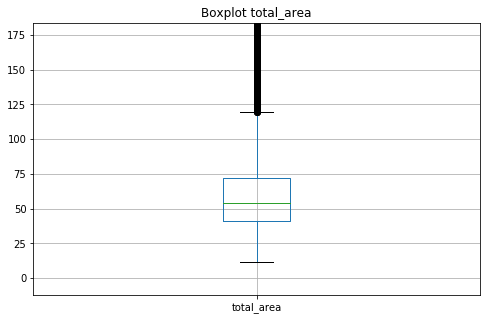

In [95]:
range_of_good_data(data, 'total_area')

###### Границы нормальных значений находятся в диапазоне **от 24 до 167 м2**, остальное выбросы

###### Цена

Граница нормальных заначений равна:
  Нижняя: 2150000
  Верхняя: 18150000
Вне границ выбросы
  Медиана равна 5200000.0


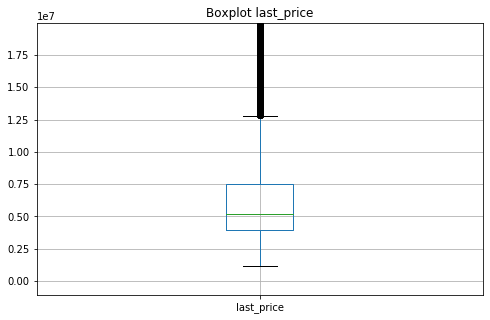

In [96]:
range_of_good_data(data, 'last_price')

 Границы нормальных значений находятся в диапазоне **от 2 150 000 до 18 150 000 руб**


Проверим основные метрики для кватрир дороже 18 150 000 руб

Проверим взаимосвязь цены продажи между:
+ числом комнат
+ ценой за квадратный метр
+ общей площади
+ расположения этажа

In [97]:
data.query('last_price > 18150000').describe()

,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,floor,floors_total,balcony,airports_nearest,...,days_exposition,total_images,year_exposition,month_exposition,sqr_meter_cost,weekday_exposition,floor_location_id,living_area_deal,kitchen_area_deal,locality_id
count,831.00,831.00,831.00,831.00,831.00,831.00,831.00,831.00,831.00,831.00,...,831.00,831.00,831.00,831.00,831.00,831.00,831.00,831.00,831.00,831.00
mean,"38,948,755.07",3.96,170.45,96.85,25.40,3.02,5.81,8.81,0.52,"27,295.72",...,271.47,12.46,"2,017.09",6.48,"232,693.39",2.57,1.14,1.93,8.80,0.26
std,"44,748,785.35",1.77,87.54,55.86,15.43,0.43,4.34,5.10,1.05,"7,514.03",...,266.34,6.82,1.24,3.61,"155,615.45",1.76,0.48,1.62,13.63,1.98
min,"18,200,000.00",0.00,33.00,3.00,1.00,2.50,1.00,2.00,0.00,"9,222.00",...,3.00,0.00,"2,014.00",1.00,"43,402.78",0.00,0.00,1.05,1.57,0.00
25%,"21,500,500.00",3.00,117.30,60.55,15.00,2.65,3.00,5.00,0.00,"23,127.00",...,111.00,7.00,"2,016.00",3.00,"149,244.20",1.00,1.00,1.56,5.41,0.00
50%,"26,000,000.00",4.00,148.00,81.70,21.00,3.00,5.00,7.00,0.00,"25,988.00",...,156.00,14.00,"2,017.00",6.00,"191,532.26",3.00,1.00,1.77,7.18,0.00
75%,"37,999,500.00",5.00,194.90,112.00,30.10,3.20,7.00,10.50,1.00,"31,706.00",...,348.50,19.00,"2,018.00",10.00,"269,096.17",4.00,1.00,2.00,9.81,0.00
max,"763,000,000.00",19.00,900.00,413.25,135.00,6.00,25.00,26.00,5.00,"70,016.00",...,"1,572.00",50.00,"2,019.00",12.00,"1,907,500.00",6.00,2.00,46.33,230.00,25.00


Сгруппируем по количеству комнат

In [98]:
values = ['last_price', 'total_area', 'cityCenters_nearest', 'sqr_meter_cost']
data.query('last_price > 18150000').pivot_table(index='rooms', values=values, aggfunc='median')

,cityCenters_nearest,last_price,sqr_meter_cost,total_area
rooms,,,,
0,"6,060.00",71000000,"191,374.66",371.00
1,"5,626.00",28000000,"333,289.03",75.75
2,"4,856.00",24466000,"258,762.11",95.70
3,"5,961.00",25000000,"210,850.11",124.50
4,"5,903.50",25898500,"173,625.17",155.70
5,"5,051.50",32425000,"163,433.80",200.50
6,"4,887.50",30375000,"136,931.82",231.10
7,"4,725.00",30600000,"127,551.02",253.00
8,"5,487.00",36100000,"133,134.63",275.65


Проверим аналогично основные метрики для кватрир дешевле 18 150 000 руб

In [99]:
data.query('last_price < 18150000').pivot_table(index='rooms', values=values, aggfunc='median')

,cityCenters_nearest,last_price,sqr_meter_cost,total_area
rooms,,,,
0,"14,479.00",3150000,"115,000.00",26.10
1,"14,600.00",3850000,"106,023.29",37.00
2,"13,239.00",5300000,"100,000.00",54.00
3,"13,063.00",6580000,"92,893.12",72.65
4,"10,581.00",8500000,"89,836.07",95.00
5,"4,669.00",11500000,"87,483.18",127.00
6,"4,575.50",13000000,"87,303.36",152.10
7,"4,563.00",15175000,"85,283.39",175.00
8,"3,480.00",16300000,"72,760.89",232.70


Наблюдается резкое изменение в стоимости за 1 кв.м

Проверим данные для квартир, чья цена более 18 150 000 и меньше 2-комнат

In [100]:
data.query('(last_price > 18150000) & (rooms < 2)')[values].describe()

,last_price,total_area,cityCenters_nearest,sqr_meter_cost
count,13.00,13.00,13.00,13.00
mean,"33,085,809.85",127.48,"4,983.31","410,497.24"
std,"14,492,449.42",140.43,"2,082.96","243,819.28"
min,"18,500,000.00",33.00,"1,376.00","87,402.00"
25%,"21,821,800.00",55.30,"4,243.00","280,000.00"
50%,"28,000,000.00",76.00,"5,955.00","310,164.24"
75%,"39,900,000.00",122.08,"6,800.00","450,000.00"
max,"71,000,000.00",494.10,"6,941.00","848,484.85"


Проверим запись с максимальным значением 763 000 000

In [101]:
data.loc[data['last_price'] == data['last_price'].max()]

,locality_name,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,floor,floors_total,is_apartment,...,last_day_exposition,year_exposition,month_exposition,sqr_meter_cost,weekday_exposition,floor_location,floor_location_id,living_area_deal,kitchen_area_deal,locality_id
10281,санкт-петербург,763000000,7,400.00,250.00,50.00,2.65,10,10,2,...,2017-11-02,2017,9,"1,907,500.00",5,последний,2,1.60,8.00,0.00


Как видно данные значительно отличаются по своей ценовой характиристике, скорее всего это премиальное жилье, которое отличается от среднестатистического, в связи с этим, можно сделать вывод, что положительного эффекта для оценки среднестатистических квартир они не дадут, поэтому предлагается их исключить из анализа

###### Число комнат

Граница нормальных заначений равна:
  Нижняя: 0
  Верхняя: 9
Вне границ выбросы
  Медиана равна 2.0


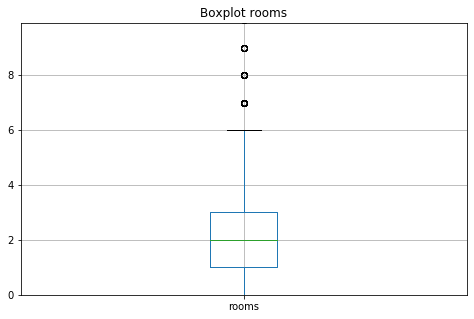

In [102]:
range_of_good_data(data, 'rooms')

Проверим для части объявлений, где не указаны число комнат, проверим выборку с фильтром rooms == 0

Граница нормальных заначений равна:
  Нижняя: 16
  Верхняя: 42
Вне границ выбросы
  Медиана равна 26.1


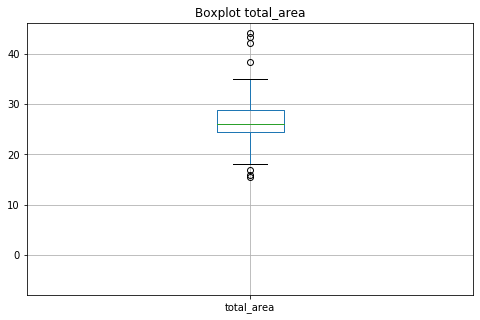

In [103]:
range_of_good_data(data.query('rooms == 0'), 'total_area')

Проверим значения общей площади для которых указыно число комнат равное 1

In [104]:
data.query('rooms == 1')['total_area'].describe()

count   6,244.00
mean       37.95
std         9.76
min        12.00
25%        32.60
50%        37.00
75%        41.50
max       494.10
Name: total_area, dtype: float64

Проверим значения общей площади и числа комнат соответствующее типу квартиры - студия

In [105]:
data.query('studio == True')[['total_area', 'rooms']].describe()

,total_area,rooms
count,114.00,114.00
mean,28.32,0.05
std,10.44,0.22
min,15.50,0.00
25%,24.25,0.00
50%,26.00,0.00
75%,29.00,0.00
max,98.40,1.00


Видим, что для графика boxplot c фильтром rooms = 0 совпадает по значениям с метриками для фильтра studio == True.
предлагается значения с числом комнат 0 заменить на 1. Т.к. в студии есть минимум 1 комната

Т.к. у нас в этой выборке имеется кватрита с площадью 371, ее просто предлагается проигнорировать, т.к. значение не попадает в интервал нормального распределения по площади

In [106]:
data.query('(rooms == 0) & (total_area > 35)')

,locality_name,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,floor,floors_total,is_apartment,...,last_day_exposition,year_exposition,month_exposition,sqr_meter_cost,weekday_exposition,floor_location,floor_location_id,living_area_deal,kitchen_area_deal,locality_id
2717,санкт-петербург,7400000,0,73.60,50.00,5.20,2.65,1,3,2,...,2017-07-17,2017,5,"100,543.48",3,первый,0,1.47,14.15,0.00
7165,санкт-петербург,3890000,0,38.30,24.42,4.30,2.70,7,14,2,...,2018-07-22,2017,10,"101,566.58",4,другой,1,1.57,8.90,0.00
7931,санкт-петербург,5050000,0,44.20,32.20,1.00,2.70,1,9,2,...,2017-11-22,2017,9,"114,253.39",3,первый,0,1.37,44.20,0.00
10788,санкт-петербург,8100000,0,58.40,33.00,10.80,3.30,6,7,2,...,2019-04-26,2019,4,"138,698.63",4,другой,1,1.77,5.41,0.00
12150,санкт-петербург,5970000,0,43.30,28.20,4.28,2.80,2,9,2,...,2017-08-19,2017,7,"137,875.29",3,другой,1,1.54,10.13,0.00
12790,санкт-петербург,5000000,0,42.10,30.00,1.58,2.65,10,20,2,...,2018-09-30,2018,4,"118,764.85",4,другой,1,1.40,26.73,0.00
15391,санкт-петербург,71000000,0,371.00,209.70,68.55,3.57,6,7,2,...,2018-10-24,2018,7,"191,374.66",3,другой,1,1.77,5.41,0.00
15913,санкт-петербург,16300000,0,98.40,60.50,13.30,3.10,2,5,2,...,2019-04-29,2017,11,"165,650.41",2,другой,1,1.63,7.40,0.00
16805,санкт-петербург,8200000,0,71.00,68.00,1.00,5.80,5,5,2,...,2017-08-20,2017,7,"115,492.96",4,последний,2,1.04,71.00,0.00


In [107]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

Граница нормальных заначений равна:
  Нижняя: 1
  Верхняя: 9
Вне границ выбросы
  Медиана равна 2.0


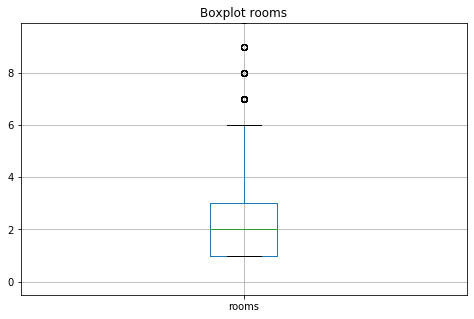

In [108]:
range_of_good_data(data, 'rooms')

Границы нормальных значений находятся в диапазоне **от 1 до 9 комнат**

###### Высота потолков

Граница нормальных заначений равна:
  Нижняя: 2
  Верхняя: 3
Вне границ выбросы
  Медиана равна 2.6


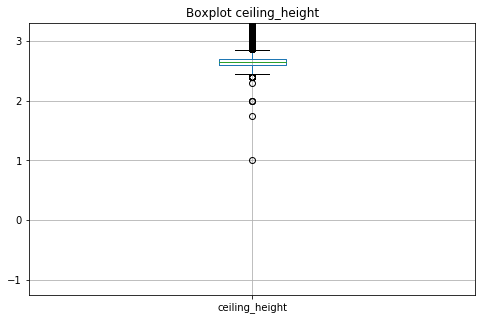

In [109]:
range_of_good_data(data, 'ceiling_height')

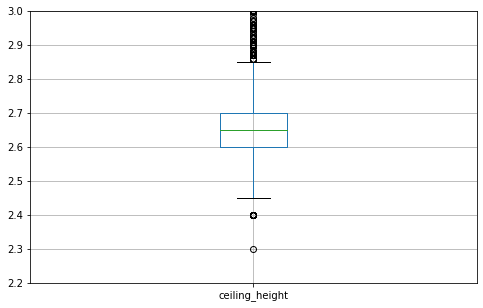

In [110]:
plt.ylim(2.2, 3)
data.boxplot(column='ceiling_height')

Границы нормальных значений находятся в диапазоне **от 2,4 до 3 метров**

###### Проверим данные с высотой потолков более 3-х метров

Насколько известно высота потолков для Спб до 6 метров является вполне нормальной, учитывая архетектурные решеня разных годов

In [111]:
cols = ['last_price', 'rooms', 'total_area', 'ceiling_height', 'floor', 'floors_total', 'cityCenters_nearest']
data[cols].query('ceiling_height > 3').describe()

,last_price,rooms,total_area,ceiling_height,floor,floors_total,cityCenters_nearest
count,"1,461.00","1,461.00","1,461.00","1,461.00","1,461.00","1,461.00","1,461.00"
mean,"16,367,920.13",3.13,104.78,3.67,3.88,6.30,"6,879.26"
std,"23,814,637.01",1.53,66.59,3.44,2.75,3.54,"7,366.28"
min,"1,850,000.00",1.00,13.00,3.01,1.00,2.00,181.00
25%,"7,200,000.00",2.00,65.00,3.15,2.00,5.00,"3,386.00"
50%,"9,990,000.00",3.00,87.00,3.26,3.00,5.00,"4,836.00"
75%,"15,990,000.00",4.00,123.10,3.50,5.00,6.00,"7,579.00"
max,"330,000,000.00",15.00,631.20,100.00,26.00,36.00,"53,138.00"


Как видно в этой выборке 75% значений не превышают 3,5 метров, и судя по удалению от центра все находится в пределах Спб

Проверим значения для высоты потолков более 6 метров

In [112]:
data[cols].query('ceiling_height > 6').describe()

,last_price,rooms,total_area,ceiling_height,floor,floors_total,cityCenters_nearest
count,21.00,21.00,21.00,21.00,21.00,21.00,21.00
mean,"5,735,666.67",1.86,52.31,25.51,6.95,11.95,"14,878.38"
std,"2,757,554.96",0.73,18.59,18.60,5.93,8.47,"10,182.68"
min,"3,000,000.00",1.00,25.00,8.00,1.00,4.00,"3,246.00"
25%,"3,900,000.00",1.00,43.00,20.00,2.00,5.00,"9,760.00"
50%,"5,300,000.00",2.00,45.00,25.00,5.00,9.00,"12,570.00"
75%,"5,950,000.00",2.00,58.00,27.00,13.00,16.00,"15,543.00"
max,"15,000,000.00",3.00,92.90,100.00,19.00,36.00,"50,649.00"


In [113]:
data[cols].query('ceiling_height > 6')['ceiling_height'].value_counts()

27.00     5
25.00     4
8.00      2
8.30      1
22.60     1
10.30     1
100.00    1
32.00     1
27.50     1
20.00     1
14.00     1
26.00     1
24.00     1
Name: ceiling_height, dtype: int64

Число комнат не превышает 3-х, каких то аномалий по остальным колонкам тоже не наблюдается

Вероятно, пользователем было некорректно указано значение высоты потолка. т.е. в место записи 2,7 м было указано 27 м
Предлагается заменить значения в диапазоне от 20 до 40 на значения деленное на 10

In [114]:
data.loc[(data['ceiling_height'] >= 20)
              & (data['ceiling_height']  <= 40)
                 , 'ceiling_height'] = (
    data.loc[(data['ceiling_height'] >= 20)
              & (data['ceiling_height']  <= 40)
                 , 'ceiling_height'] / 10
)


In [115]:
data[cols].query('ceiling_height >= 6').describe()

,last_price,rooms,total_area,ceiling_height,floor,floors_total,cityCenters_nearest
count,7.00,7.00,7.00,7.00,7.00,7.00,7.00
mean,"23,071,428.57",2.00,68.57,22.09,7.00,11.29,"12,756.29"
std,"42,448,634.23",1.15,54.07,34.45,5.51,5.35,"7,231.34"
min,"5,300,000.00",1.00,25.00,6.00,1.00,5.00,"5,605.00"
25%,"5,475,000.00",1.00,45.00,8.00,3.50,6.00,"9,523.00"
50%,"5,600,000.00",2.00,54.00,8.30,5.00,14.00,"11,035.00"
75%,"10,325,000.00",2.50,61.70,12.15,10.50,16.00,"12,773.00"
max,"119,000,000.00",4.00,187.60,100.00,15.00,16.00,"28,062.00"


Предлагается выбрать значения высоты потолков **от 2,4 до 6-ти метров**

##### Отсортируем данные исключив выбросы и сохраним в переменной data_good

In [116]:
data_good = (
    data.loc[
        (data['total_area'] >= 24) & (data['total_area'] <= 167)
        & (data['last_price'] >= 2150000) & (data['last_price'] <= 18150000)
        & (data['rooms'] >= 1) & (data['rooms'] <= 9)
        & (data['ceiling_height'] >= 2.4) & (data['ceiling_height'] <= 6)]
)

In [117]:
data_good.describe()

,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,floor,floors_total,balcony,airports_nearest,...,days_exposition,total_images,year_exposition,month_exposition,sqr_meter_cost,weekday_exposition,floor_location_id,living_area_deal,kitchen_area_deal,locality_id
count,"17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00",...,"17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00","17,674.00"
mean,"5,981,011.91",2.03,57.38,32.81,10.19,2.70,6.30,11.54,0.60,"29,576.38",...,176.73,9.90,"2,017.35",6.42,"104,345.14",2.56,1.02,1.85,inf,1.60
std,"2,955,326.32",0.96,23.02,15.74,4.75,0.21,5.08,6.68,0.96,"13,232.70",...,207.17,5.66,1.04,3.47,"26,694.99",1.79,0.48,0.45,nan,4.65
min,"2,150,000.00",1.00,24.00,2.00,0.00,2.40,1.00,1.00,0.00,0.00,...,1.00,0.00,"2,014.00",1.00,"15,861.57",0.00,0.00,1.00,1.38,0.00
25%,"3,950,000.00",1.00,40.20,19.00,7.00,2.60,3.00,5.00,0.00,"18,542.00",...,45.00,6.00,"2,017.00",3.00,"86,440.68",1.00,1.00,1.58,4.37,0.00
50%,"5,095,000.00",2.00,52.00,30.00,9.30,2.65,5.00,9.00,0.00,"27,570.00",...,117.00,10.00,"2,017.00",6.00,"100,000.00",3.00,1.00,1.77,5.59,0.00
75%,"7,000,000.00",3.00,69.00,42.00,12.00,2.70,9.00,16.00,1.00,"39,140.00",...,201.00,14.00,"2,018.00",10.00,"117,220.70",4.00,1.00,2.00,7.37,0.00
max,"18,130,500.00",8.00,167.00,140.00,64.00,5.80,33.00,60.00,5.00,"84,869.00",...,"1,553.00",50.00,"2,019.00",12.00,"387,096.77",6.00,2.00,26.00,inf,26.00


##### Построим гистограммы для величин: площадь, цена, число комнат, высота потолков

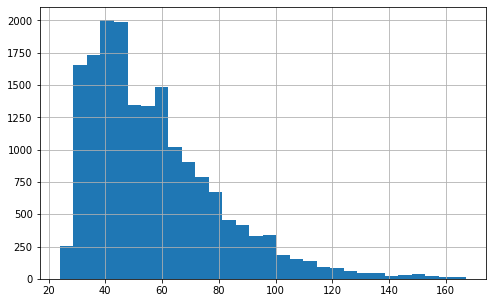

In [118]:
data_good['total_area'].hist(bins=30)

Гистограмма имеет вид распределения типа Пуассона.

Наблюдается 3 основных пика, вероятнее всего это связвнно с количеством комнат
ПОстроим гистограмму с разбивкой по комнатам

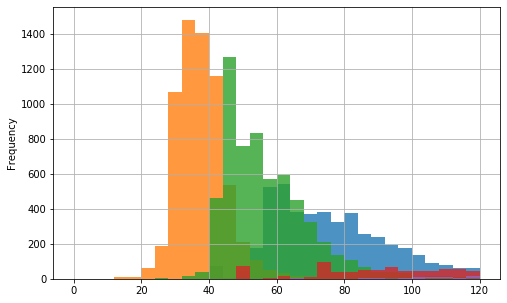

In [119]:
# Проверим для квартир с различным количество комнат
for element in data_good['rooms'].unique():
    data.query('rooms == @element')['total_area'].plot(kind='hist', bins=30, range=(0, 120), alpha=0.8, grid=True)

На графике видно
1. наложение синего и оранжевого цвета - пик при значении около 45
2. Пик в районе 35
3. Пик в районе 60.

Да это влияние квартир с различным количеством комнат

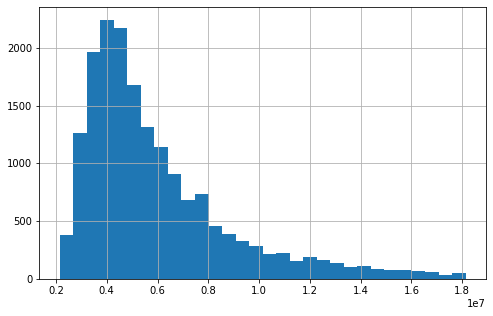

In [120]:
data_good['last_price'].hist(bins=30)

Гистограмма имеет вид распределения типа Пуассона

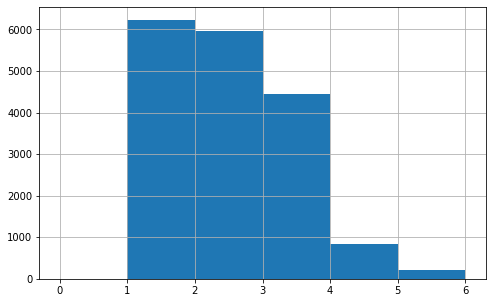

In [121]:
data_good['rooms'].hist(bins=6, range=(0, 6))

Гистограмма имеет вид распределения типа Пуассона

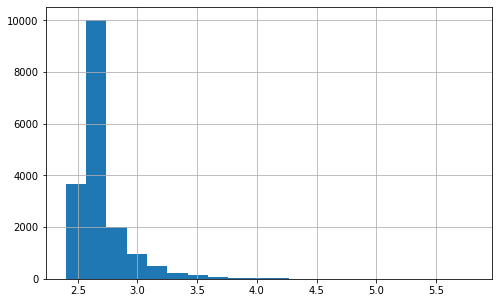

In [122]:
data_good['ceiling_height'].hist(bins=20)

Гистограмма имеет вид распределения больше похожий на Пуассона

#### Вывод
1. Мы определили выбросы для каждой из величин: площадь, цена, число комнат, высота потолков;
2. Для определения выбросов использовали визуализацию boxplot()
3. Исключили выбросы из имеющейся выборки;
4. Создали новую выборку содержащую только "хорошие" данные
5. Построили гистограммы для величин: площадь, цена, число комнат, высота потолков;
6. В гистограммах отмечено преимущественно распределение Пуасонна:
 + только для общей площади 1-комнатных квартир соответствует нормальному типу гистограммы.

#### 3.2. Изучим время продажи квартиры.

In [123]:
#Проверим основные метрики для days_exposition
data_good['days_exposition'].describe()

count   17,674.00
mean       176.73
std        207.17
min          1.00
25%         45.00
50%        117.00
75%        201.00
max      1,553.00
Name: days_exposition, dtype: float64

Проверим влияние других величин на days_exposition


In [124]:
corr_chek(data_good, 'days_exposition')

,corr
column,
total_area,0.16
last_price,0.14
living_area,0.14
rooms,0.11
kitchen_area,0.10
total_images,-0.04
floors_total,-0.05
cityCenters_nearest,-0.05
ponds_nearest,-0.05


Можем сделать вывод, что наиболее ярко выражена корреляция с годом публикации

Построим boxplot по годам

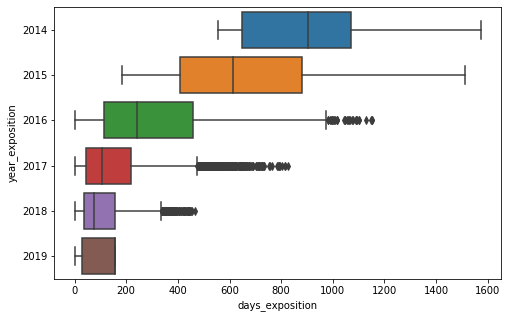

In [125]:
cols = ['days_exposition', 'year_exposition']
sns.boxplot(y="year_exposition", x="days_exposition", data=data[cols], orient="h")
plt.show()

Построим сденее и медиану с группировкой по годам

In [126]:
data_good[cols].pivot_table(index='year_exposition', values='days_exposition', aggfunc=('median', 'mean'))

,mean,median
year_exposition,,
2014,897.01,890.00
2015,651.53,598.50
2016,314.80,236.00
2017,154.51,103.00
2018,97.99,74.00
2019,104.38,156.00


значения в 2019 году несколько выше, но это скорее всего связано с качеством данных - за 2019 у нас информация только за 1-е полугодие

Проверим количество поданных объявлений по годам

In [127]:
data_good.groupby('year_exposition')['days_exposition'].count()

year_exposition
2014      92
2015     894
2016    2102
2017    6265
2018    6209
2019    2112
Name: days_exposition, dtype: int64

На сколько мы помним,
в Шаге предобработка данных мы делали анализ `'days_exposition'` по годам на предмет определения пропусков, и их соотношения с заполнеными ячейкам.
Приняли, то что пропуск в `'days_exposition'` в 2017 году является отсутствием продаж:
+ Для 2017 года количество объявлений без пропусков составило 97% (т.е. проданных)
+ Для 2018 только 89%

**Всвязи с этим в качестве оценки скорости продажи примем данные для 2017-2018 годов**

>Почему не приняли года ренее 2017?: 
Количество объявлений, а также распределение на диаграмме boxplot соответствует, тому, что пользователи менее активно пользовались сервисом - **данные не релевантны**

>Почему не приняли 2019 год?:
Данные в 2019 году только за первое полугодие, т.е. мы имее только "быстрые" продажи - может искозить результат.

> Так же отмечается то, что **за первую половину 2019 года было подано всего лишь 30% объявлений** от предыдущего года - популярность ресурса снижается - звоночик к активным действиям

In [128]:
# Проверим основные метрики
a = data_good.query('(year_exposition == 2017) | (year_exposition == 2018)')['days_exposition']
a.describe()

count   12,474.00
mean       126.38
std        123.13
min          3.00
25%         41.00
50%         89.00
75%        159.00
max        814.00
Name: days_exposition, dtype: float64

Построим график распределения величин `'days_exposition'` в соответствии с процентилем

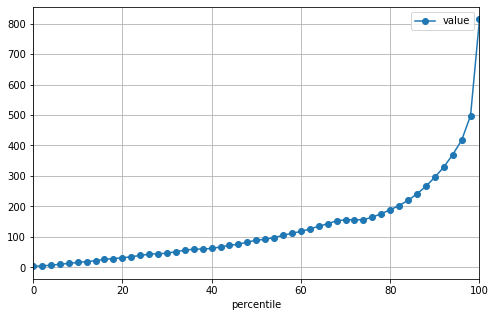

In [129]:
quickly_of_sales = []
for i in range(0, 102, 2) :
    q = np.percentile(a, i).astype(int)
    quickly_of_sales.append(q)

quickly_of_sales = pd.DataFrame(
    {'percentile': np.arange(0, 102, 2), 
     'value': quickly_of_sales})

quickly_of_sales.plot(
    x='percentile', y='value',
    style='o-', grid=True
)
plt.show()

Как видно на графике зависимость времени продажи от процентиля:
+ до 40 имеет небольшую линейную зависимость;
+ с 40 до 74-го наклон увеличивается;
+ начиная с 74-го имеет экспоненциальный характер роста;
+ особенно быстрое увеличение начинается с 84-го процентиля;
+ далее 90 процентиля скорость роста наблюдается особо быстрой


Проверим значения при 40-м и 74-м и 84-м процентиле

In [130]:
print(np.percentile(a, [40, 74, 84]))
# Значения отличаются почти в 2,5 раза между 40-м и 74-м, b yf 37% между 74 и 84 
del a

[ 62. 156. 220.]


Поэтому можно сделать вывод, что продажи более 214 дней являются долгими, ведь при попадании за времени продажи в диапазон после 217 дней повышает вероятность того, что квартира будет продаваться еще дольше.

#### Вывод:
Актуальные значения (по результатам 2017-2018 года) составляют:
1. Медиана время продажи: 84 дня;
2. Среднее значение время продажи: 124 деня
3. в среднем продажа занимает от 39 дней до 156 (1-й и 3-й квартиль)
4. До 62 дней - можно считать, что продажи прошли быстро
5. более 220 дней - долгие продажи



##### Изучим влияние факторов на цену квартиры, для этого проверим корреляцию величин

In [131]:
def corr_chek_all_sings(df, column):
    """
    Функция возращает таблицу cо значениями корреляции относительно других величин
    Полученная таблица отсортирована по убыванию
    """
    s1 = df[column]
    corr_values = []
    columns = []
    for name in df.columns:
        s2 = df[name]
        try:
            if name != column:
                corr_value = s1.corr(s2)
            else:
                corr_value = np.na
        except:
            corr_value = None
            
        corr_values.append(corr_value)
        columns.append(name)
    d = {'column': columns, 'corr': corr_values}
    corr_data = pd.DataFrame(data=d).sort_values(by='corr', ascending=False).dropna()
    return corr_data

In [132]:
corr_chek_all_sings(data_good, 'last_price')

,column,corr
3,total_area,0.81
4,living_area,0.70
5,kitchen_area,0.58
2,rooms,0.54
25,sqr_meter_cost,0.54
6,ceiling_height,0.41
17,ponds_around3000,0.21
15,parks_around3000,0.19
21,total_images,0.15
20,days_exposition,0.14


Проверим для величин перечисленных в задании, добавим id населенного пункта и количество комнат

In [133]:
cols1 = ['last_price', 'rooms', 'sqr_meter_cost', 'total_area', 'floor_location_id']
cols2 = ['last_price', 'cityCenters_nearest', 'locality_id']
cols3 = ['last_price', 'year_exposition', 'month_exposition', 'weekday_exposition']

Проверим взаимосвязь цены продажи между:
+ числом комнат
+ ценой за квадратный метр
+ общей площади
+ расположения этажа

In [134]:
corr_chek_all_sings(data_good[cols1], 'last_price')

,column,corr
3,total_area,0.81
1,rooms,0.54
2,sqr_meter_cost,0.54
4,floor_location_id,0.06


Наибольшая корреляци наблюдается для:
+ общей площади
+ чуть менее для числа комнат и цены за кв.м
+ расположение этажа не сильно влияет

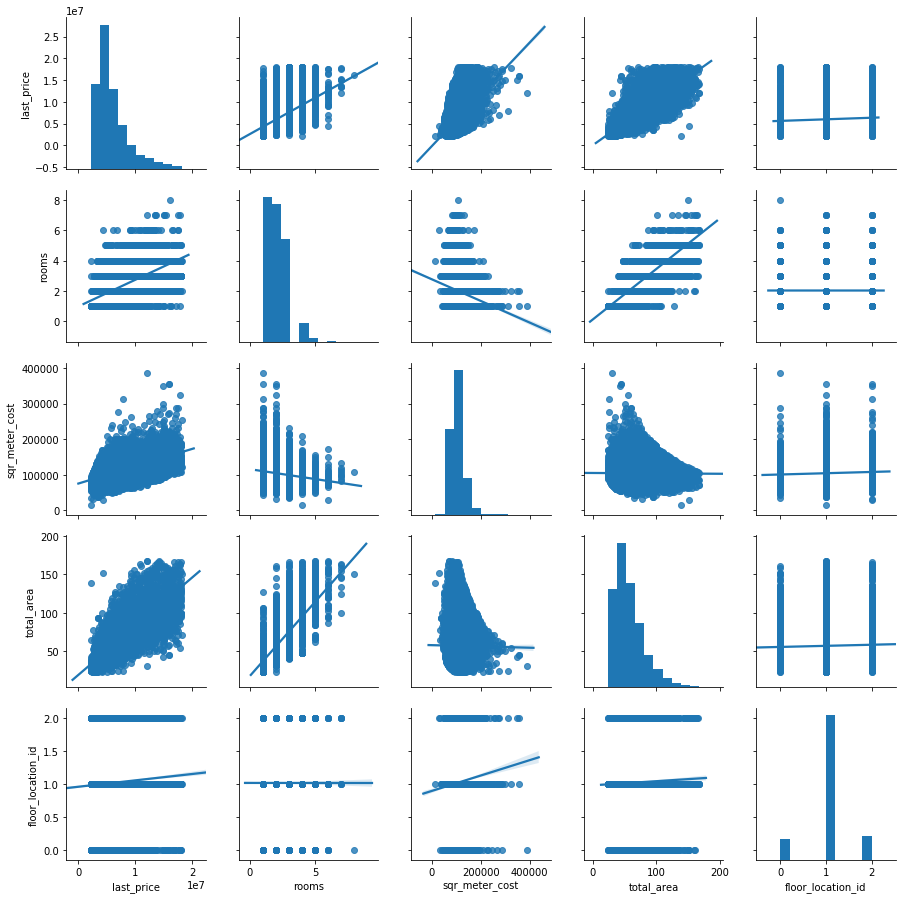

In [135]:
sns.pairplot(data_good[cols1], kind='reg')
plt.show()

Проверим взаимосвязь цены продажи между:
+ населенным пунктом
+ удаленность от центра

In [136]:
corr_chek_all_sings(data_good[cols2], 'last_price')
plt.show()

Наблюдается обратная связь с вышеуказанными величинами

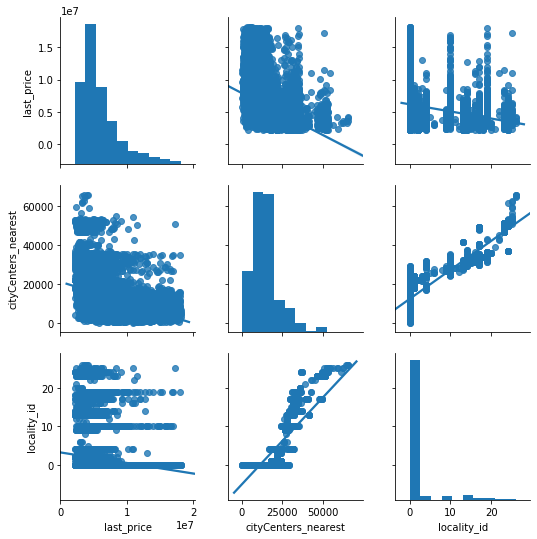

In [137]:
sns.pairplot(data_good[cols2], kind='reg')
plt.show()

Проверим взаимосвязь цены продажи между:
+ год публикации
+ месяц публикации
+ день недели публикации

In [138]:
corr_chek_all_sings(data_good[cols3], 'last_price')

,column,corr
2,month_exposition,-0.00
1,year_exposition,-0.01
3,weekday_exposition,-0.02


цена в зависимости от года, месяца и дня недели практически не менялась

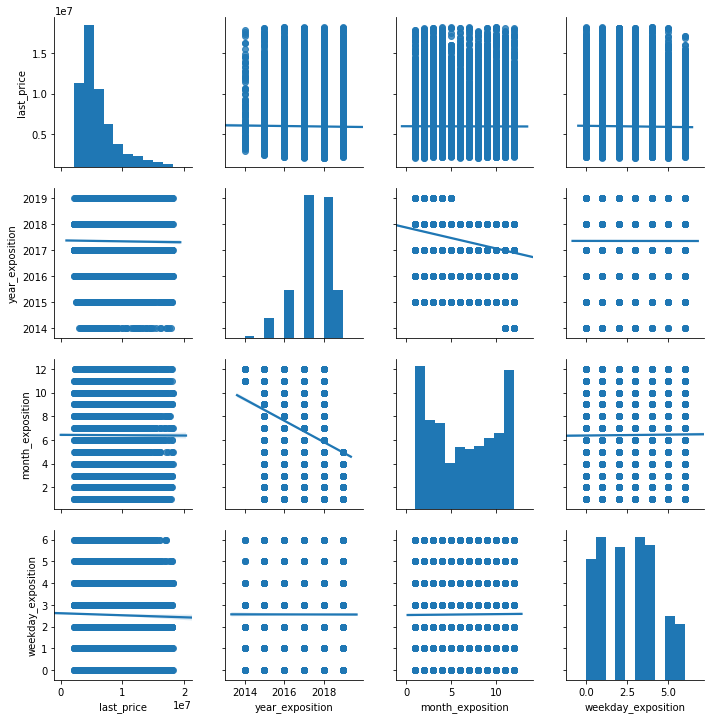

In [139]:
sns.pairplot(data_good[cols3], kind='reg')
plt.show()

##### Вывод
Наибольшая взаимосвязь цены продажи наблюдается с:
+ общей площадью
+ чуть менее с числом комнат и ценой за кв.м
+ расположение этажа не сильно влияет

Также наблюдается взаимосвязь с:
+ количеством комнат
+ высотой потолка

Чуть меньшая обратная связь наблюдается с:
+ удаленностью от центра города

##### "Выберем 10 населённых пунктов с наибольшим числом объявлений. Определим среднюю цену квадратного метра в этих населённых пунктах.

In [140]:
cols = ['locality_name', 'sqr_meter_cost']
top_10_cities = (
    data_good[cols]\
    .pivot_table(index='locality_name', aggfunc=('mean', 'count'))\
    .sort_values(by=[('sqr_meter_cost','count')], ascending=False)\
    .iloc[:10]
)
top_10_cities.columns = ['ads_number', 'mean_of_sqr_meter']
top_10_cities.style.bar()\
    .set_caption('Средняя цена квадратного метра для 10 населенных пунктов с наибольшим количеством объявлений')

,ads_number,mean_of_sqr_meter
locality_name,,
санкт-петербург,14721,108220
поселок мурино,524,85702.8
поселок шушары,430,78622.8
пушкин,356,101930
колпино,333,75281.4
поселок парголово,322,90724.1
петергоф,197,84445.8
сестрорецк,180,101679
красное село,171,72296.8


В Пушкине и Сестрорецке квартиры стоят почти столькоже, как и в Спб

##### Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'. "

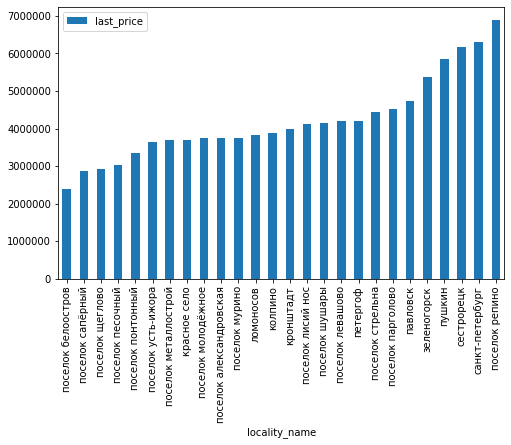

In [141]:
gpouped_by_cities = data_good.pivot_table(index='locality_name', values='last_price').sort_values(by='last_price').reset_index()
gpouped_by_cities.plot(x='locality_name', y ='last_price', kind='bar')
plt.show()

In [142]:
print('Самая низкая цена квартир в: {}, среднее значение составляет {:.0f} руб\n'\
      .format(gpouped_by_cities.loc[0, 'locality_name'],
              gpouped_by_cities.loc[0, 'last_price']))
print('Самые дорогие квартиры в: {}, среднее значение составляет {:.0f} руб\n'\
      .format(gpouped_by_cities.loc[(len(gpouped_by_cities)-1), 'locality_name'],
              gpouped_by_cities.loc[(len(gpouped_by_cities)-1), 'last_price']))

Самая низкая цена квартир в: поселок белоостров, среднее значение составляет 2400000 руб

Самые дорогие квартиры в: поселок репино, среднее значение составляет 6889139 руб



##### Вывод:
Самая низкая цена квартир в: поселке Белоостров, среднее значение составляет 2 400 000 руб

Самые дорогие квартиры в: поселке Репино, среднее значение составляет почти 6 900 000 руб

#### 3.4. Удаленность от центра города

In [143]:
# Добавим колонку с километрами от центра, величины округлим до верхнего значения
data_good['cityCenters_nearest_km'] = data_good.cityCenters_nearest.apply(lambda x: int(np.ceil(x / 1000)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
#Посчитаем среднюю цену для каждого километра
grouped_km_data_spb = data_good\
    .query('locality_name == "санкт-петербург"')\
    .pivot_table(index='cityCenters_nearest_km', values=('last_price', 'sqr_meter_cost'))\
    .reset_index()

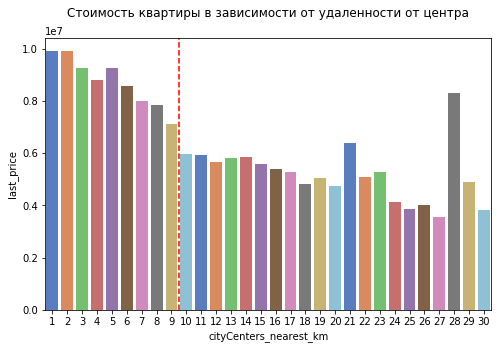

In [145]:
plt.title('Стоимость квартиры в зависимости от удаленности от центра\n')
sns.barplot(x="cityCenters_nearest_km", y="last_price", data=grouped_km_data_spb, palette="muted")
plt.axvline(8.5, color='r', linestyle='dashed')
plt.show()

##### Вывод
На графике наблюдается, что начиная с 10-го километра цена квартир резко снижается.
Центральная зона заканчивается 9-м километром.

#### 3.4. Анализ квартир в центре

In [146]:
# Выделим квартиры в центре Спб
flat_in_Center = data_good.query('(locality_name == "санкт-петербург") & (cityCenters_nearest_km <= 9)')

In [147]:
print('Количество объявлений о продаже в центре города за все время составило: {}'.format(len(flat_in_Center)))

Количество объявлений о продаже в центре города за все время составило: 3643


проанализируем следующие параметры:
+ площадь, цена, число комнат, высота потолков

Основные показатели для total_area слудеющие:

         - среднее значение: 72
         - медиана         : 68
         - максимум        : 167
         - минимум         : 24



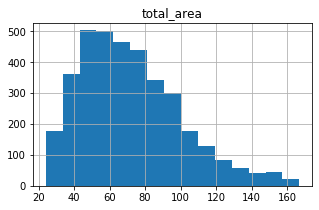

Основные показатели для last_price слудеющие:

         - среднее значение: 8499735
         - медиана         : 7900000
         - максимум        : 18130500
         - минимум         : 2200000



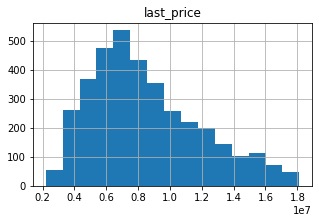

Основные показатели для rooms слудеющие:

         - среднее значение: 2
         - медиана         : 2
         - максимум        : 8
         - минимум         : 1



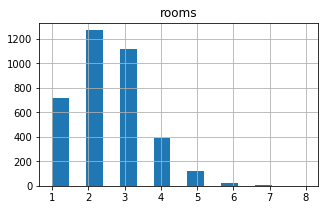

Основные показатели для ceiling_height слудеющие:

         - среднее значение: 2.88
         - медиана         : 2.71
         - максимум        : 5.80
         - минимум         : 2.40



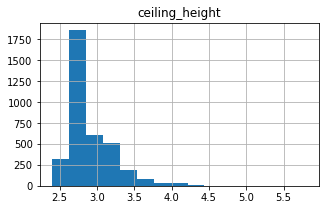

In [148]:
#СОздадим перечень исследуемых столбцов
cols = ['total_area', 'last_price', 'rooms', 'ceiling_height']

#Цикл для перебора столбцов
for column in cols:
    #Определим основные метрики
    mean = flat_in_Center[column].describe()['mean']
    median = flat_in_Center[column].describe()['50%']
    max_value = flat_in_Center[column].describe()['max']
    min_value = flat_in_Center[column].describe()['min']
    #Распечатаем метрики
    print('Основные показатели для {} слудеющие:\n'.format(column))
    if column != 'ceiling_height':
        
        print('         - среднее значение: {:.0f}'.format(mean))
        print('         - медиана         : {:.0f}'.format(median))
        print('         - максимум        : {:.0f}'.format(max_value))
        print('         - минимум         : {:.0f}'.format(min_value))
    #Для высоты потолком с 2-мя знаками после запятой
    else:
        print('         - среднее значение: {:.2f}'.format(mean))
        print('         - медиана         : {:.2f}'.format(median))
        print('         - максимум        : {:.2f}'.format(max_value))
        print('         - минимум         : {:.2f}'.format(min_value))
    
    flat_in_Center[column].hist(bins=15, figsize=(5,3))
    plt.title(column)
    print()
    plt.show()

Проверим взаимосвязь в центральной черте города и сравним общими показателями

In [149]:
# Создадим таблицу с коэффициентами корреляци для выборки центр Спб и общей выборкой
center_last_price_relation = corr_chek_all_sings(flat_in_Center, 'last_price')
spb_last_price_relation = corr_chek_all_sings(
    data_good.query('locality_name == "санкт-петербург"'),'last_price'
                                             )
#Соеденим таблицы
center_last_price_relation = spb_last_price_relation.merge(center_last_price_relation,
                                                   left_index=True, right_index=True,
                                                  suffixes=('_spb', '_center')
                                                  )
#Переименуем колонки и удалим лишние
center_diffe_form_spb = center_last_price_relation[['column_spb', 'corr_spb', 'corr_center']]
center_diffe_form_spb.columns = ['feature', 'corr_spb', 'corr_center']

#Найдем величину на сколько изменился коэффициент корреляции
center_diffe_form_spb['corr_dif'] = center_diffe_form_spb['corr_spb'] - center_diffe_form_spb['corr_center']

In [150]:
center_diffe_form_spb


,feature,corr_spb,corr_center,corr_dif
3,total_area,0.82,0.74,0.08
4,living_area,0.70,0.62,0.08
5,kitchen_area,0.60,0.51,0.09
2,rooms,0.54,0.49,0.05
25,sqr_meter_cost,0.51,0.41,0.10
6,ceiling_height,0.40,0.23,0.17
17,ponds_around3000,0.20,0.10,0.10
15,parks_around3000,0.16,0.06,0.10
20,days_exposition,0.15,0.14,0.01
21,total_images,0.13,0.10,0.03


Насколько видно из таблицы:
1. Наибольшую взаимосвязь для центральной зоны СПб имеют следующие критерии:
 + Площадь квартиры (общая, жилая, кухонная);
 + Количество комнат;
 + стоимость 1-го кв. м.
 + в меньшей степени высота потолков и удаленость непосредственно от центра
 + остальные величины имеют слабую взаимосвязь или вообще практически не имеют


2. Перечисленные характеристики в п.2 более сильно влияют для города в целом, чем для его центра
 + наблюдается, более сильная взаимосвязь у центра города связаная с выбором этажа, но вообщем она слабо влияет на цену

### Шаг 5. Общий вывод

1. Мы получили данные с большим количеством пропусков в колонках связанных с расстоянием, т.к. по условию эти колонки заполнялись автоматически, а не пользователем, то следует обратиться к источнику с вопросом о корректности заполнения
2. Пропуски были заполнены исходя из среднего или медианного распределения по группам.
3. Беря во внимание количество поданных объявлений с разбивкой по годам, можно сделать вывод, что начиная с 2014 года популярность ресурса растет, однако в 2019 году зафиксированно только 30% от прошлого года.
4. В работе мы также опредилили нормальный диапазон величин и исключили вырбосы не входящие в него. Нормальный диапазон мы нашли при помощи межквартильного размаха. В качестве нормальных значений выбрали значения в диапазоне от 0,5-го квантиля до Q3 + 3* IQR
5. В качестве оценки продажи квартиры приляни усредненные значения за 2017-2018 год, т.к. за предыдущие года наблюдался более низких пользовательский спрос на этот ресурс, а для 2019 присутствует большое количество пропусков и год еще не завершился
 Актуальные значения (по результатам 2017-2018 года) составляют:
  + Медиана время продажи: 84 дня;
  + Среднее значение время продажи: 124 деня
  + в среднем продажа занимает от 39 дней до 156 (1-й и 3-й квартиль)
  + До 62 дней - можно считать, что продажи прошли быстро
  + более 220 дней - долгие продажи
  
  
6. Нашли взаимосвязь стоимости квартиры с другими величинами:
 Наибольшая взаимосвязь цены продажи наблюдается с:
 + общей площадью
 + чуть менее с числом комнат и ценой за кв.м
 + расположение этажа не сильно влияет

 Также наблюдается взаимосвязь с:
 + количеством комнат
 + высотой потолка

 Чуть меньшая обратная связь наблюдается с:
 + удаленностью от центра города
 
 
7.Нашли населенные пункты с самым дешевым жильем и самым дорогим
 + Самая низкая цена квартир в: поселке Белоостров, среднее значение составляет 2 400 000 руб
 + Самые дорогие квартиры в: поселке Репино, среднее значение составляет почти 6 900 000 руб
 
 
8. Нашли границы центральной зоны Спб, которая заканчивается 9-м километром
9. Проанализировали влияние характеристик для квартир в центральном районе по отношению ко всему городу
 + Наибольшую взаимосвязь для центральной зоны СПб имеют следующие критерии:
  + Площадь квартиры (общая, жилая, кухонная);
  + Количество комнат;
  + стоимость 1-го кв. м.
 + В меньшей степени высота потолков и удаленость непосредственно от центра
 + остальные величины имеют слабую взаимосвязь или вообще практически не имеют
 + Перечисленные характеристики более сильно влияют для города в целом, чем для его центра
 + Наблюдается, более сильная взаимосвязь у центра города связаная с выбором этажа, но вообщем она слабо влияет на цену